<a href="https://colab.research.google.com/github/adigup390/deepintocnn/blob/main/W3Exercise3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available, model train on cpu')
else:
  print('Cuda is available!')

Cuda is available!


In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 0

batch_size = 20

valid_size = 0.2

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_data = datasets.CIFAR10('data', train = True, download = True, transform = transform)
test_data = datasets.CIFAR10('data', train =False , download = True, transform = transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']



Files already downloaded and verified
Files already downloaded and verified


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
  img = img/2 + 0.5
  plt.imshow(np.transpose(img, (1,2,0)))

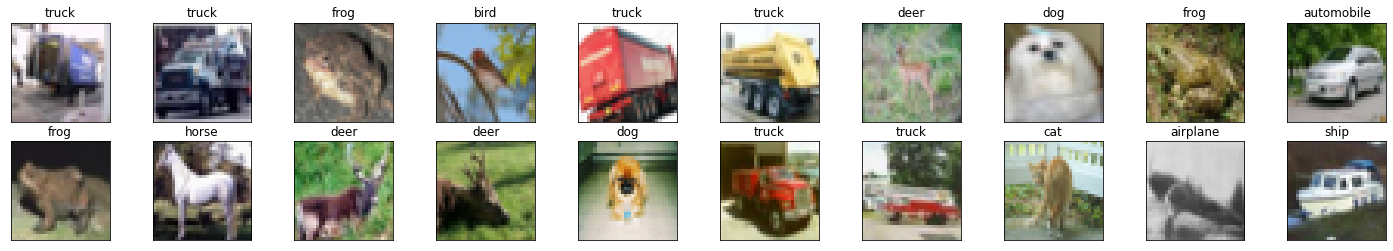

In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

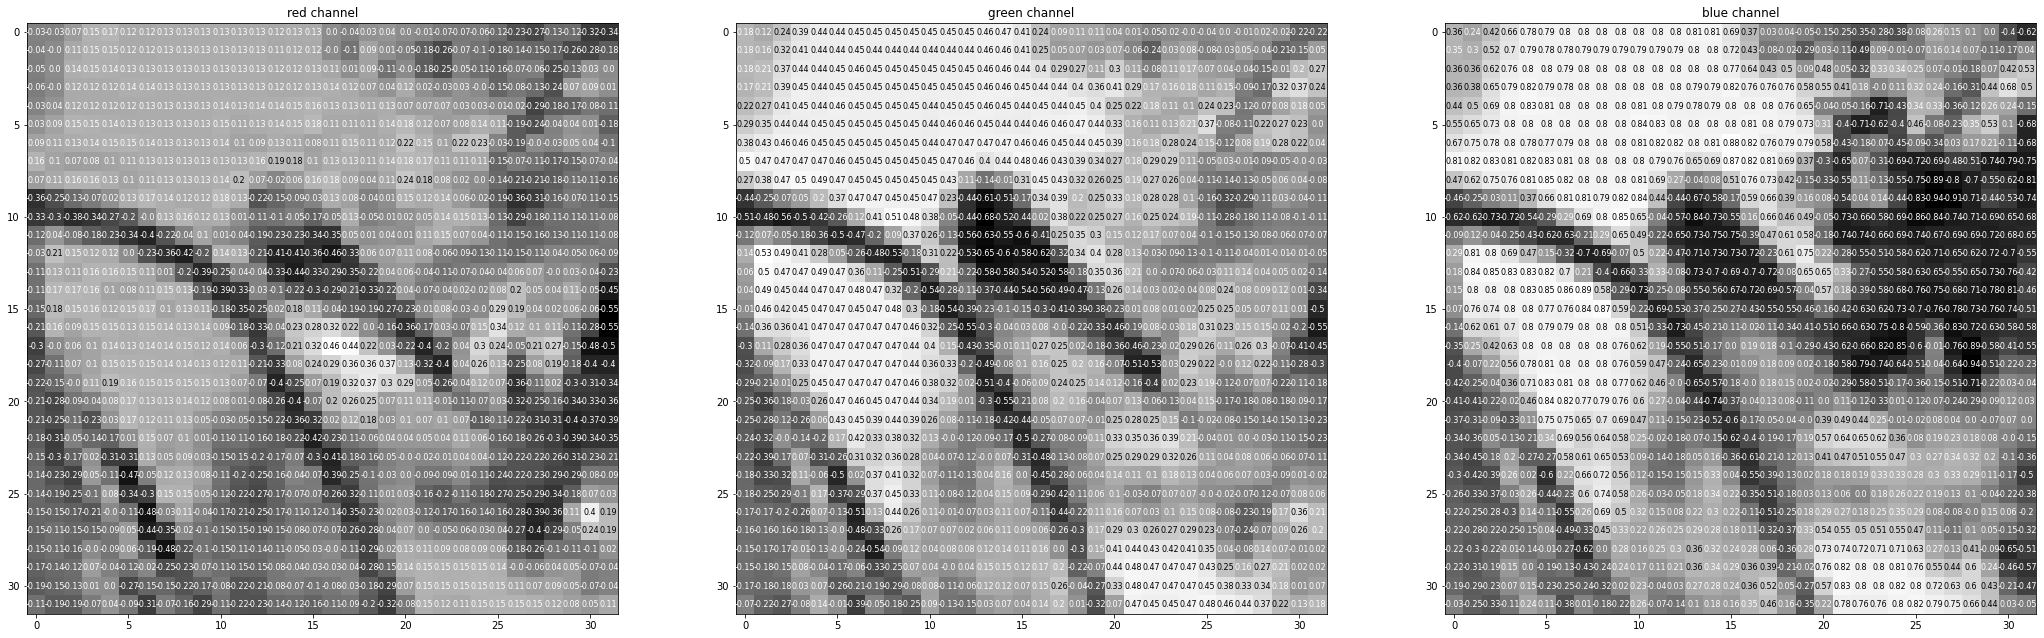

In [8]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']
fig = plt.figure(figsize = (36,36))
for idx in np.arange(rgb_img.shape[0]):
  ax = fig.add_subplot(1,3, idx+1)
  img = rgb_img[idx]
  ax.imshow(img, cmap='gray')
  ax.set_title(channels[idx])
  width, height = img.shape
  thresh = img.max()/2.5
  for x in range(width):
      for y in range(height):
          val = round(img[x][y],2) if img[x][y] !=0 else 0
          ax.annotate(str(val), xy=(y,x),horizontalalignment='center',verticalalignment='center', size=8,color='white' if img[x][y]<thresh else 'black')

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

model = Net()
print(model)

if train_on_gpu:
  model.cuda()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [11]:
import torch.optim as optim 

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

In [13]:
n_epochs = 8

valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):
  train_loss = 0.0
  valid_loss = 0.0

  model.train()
  for data, target in train_loader:
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()

      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output,target)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()*data.size(0)

  model.eval()
  for data , target in valid_loader:
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
      output = model(data)
      loss = criterion(output, target)
      valid_loss += loss.item()*data.size(0)

  train_loss = train_loss/len(train_loader.dataset)
  valid_loss = valid_loss/len(valid_loader.dataset)

  print('Epoch:{} \tTraining Loss: {:.6f} \t Validation Loss:{:.6f}'.format(epoch,train_loss, valid_loss))

  if valid_loss <= valid_loss_min:
    print('validation loss decreased ({:6f} --> {:.6f}). Saving model ...'.format(valid_loss_min,valid_loss))
    torch.save(model.state_dict(), 'model_cifar.pt')
    valid_loss_min = valid_loss

Epoch:1 	Training Loss: 0.875733 	 Validation Loss:0.227189
validation loss decreased (   inf --> 0.227189). Saving model ...
Epoch:2 	Training Loss: 0.839909 	 Validation Loss:0.224696
validation loss decreased (0.227189 --> 0.224696). Saving model ...
Epoch:3 	Training Loss: 0.810812 	 Validation Loss:0.220772
validation loss decreased (0.224696 --> 0.220772). Saving model ...
Epoch:4 	Training Loss: 0.780753 	 Validation Loss:0.214819
validation loss decreased (0.220772 --> 0.214819). Saving model ...
Epoch:5 	Training Loss: 0.753282 	 Validation Loss:0.213651
validation loss decreased (0.214819 --> 0.213651). Saving model ...
Epoch:6 	Training Loss: 0.726557 	 Validation Loss:0.214052
Epoch:7 	Training Loss: 0.700495 	 Validation Loss:0.216114
Epoch:8 	Training Loss: 0.679184 	 Validation Loss:0.222097


In [21]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:
  if train_on_gpu:
    data, target = data.cuda(), target.cuda()

    output = model(data)
    loss = criterion(output,target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(batch_size):
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'. format(test_loss))
for i in range(10):
  if class_total[i]>0:
    print('Test Accuracy of %5s:%2d%%(%2d/%2d)'%(classes[i],100*class_correct[i]/class_total[i],np.sum(class_correct[i]),np.sum(class_total[i])))

print('\nTest Accuracy of %5s: N/A(no training examples)' %(classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.112418

Test Accuracy of airplane:58%(581/1000)
Test Accuracy of automobile:82%(827/1000)
Test Accuracy of  bird:56%(561/1000)
Test Accuracy of   cat:34%(343/1000)
Test Accuracy of  deer:59%(591/1000)
Test Accuracy of   dog:47%(471/1000)
Test Accuracy of  frog:63%(632/1000)
Test Accuracy of horse:68%(684/1000)
Test Accuracy of  ship:88%(886/1000)
Test Accuracy of truck:61%(617/1000)

Test Accuracy of truck: N/A(no training examples)

Test Accuracy (Overall): 61% (6193/10000)


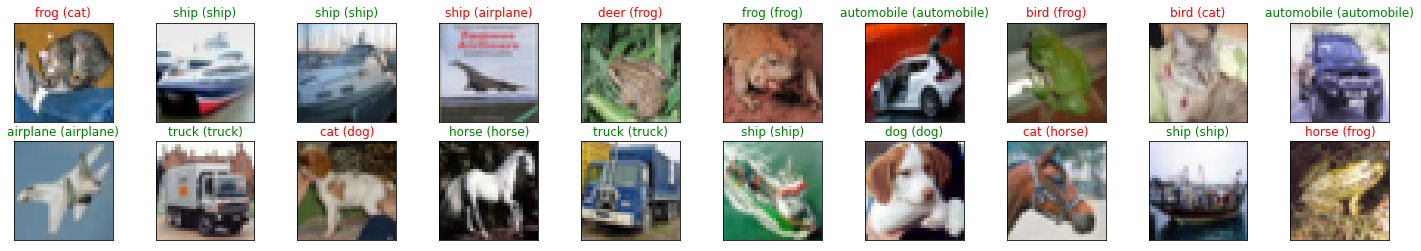

In [22]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

if train_on_gpu:
    images = images.cuda()

output = model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

if train_on_gpu:
    images = images.cpu()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))